In [1]:
import os,sys
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, roc_auc_score
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# 공통 변수
raw_data_name = 'after_eda.csv'
output_csv_name = 'output.csv'

# Code 경로 추가
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath(''))))
print(sys.path[-1])

C:\Users\Minari\Documents\GitHub\level1-classificationinmachinelearning-recsys-06


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# after_eda.csv 사용, 제외['difference', 'percent']
df = pd.read_csv(raw_data_name).drop(columns=['difference', 'percent'])
df

,ID,_type,target,hashrate,taker_buy_sell_ratio,open_interest,funding_rates,coinbase_premium_index,utxo_count,transactions_count_total,total_liquidations,liquidation_diff,total_taker_volume,estimated_block_reward_usd
0,2023-01-01 00:00:00,train,2.0,5.062917e+11,0.904774,6.271344e+09,0.005049,-0.059650,83308092.0,11457.0,0.012000,0.012000,9.785846e+07,104057.980295
1,2023-01-01 01:00:00,train,1.0,1.687639e+11,1.655721,6.288683e+09,0.005049,-0.053047,83314883.0,5832.0,0.712000,-0.712000,6.376728e+07,104403.922724
2,2023-01-01 02:00:00,train,1.0,3.375278e+11,1.027512,6.286796e+09,0.005049,-0.057952,83314090.0,5550.0,0.000000,0.000000,4.746397e+07,104021.263731
3,2023-01-01 03:00:00,train,1.0,2.109549e+11,0.874477,6.284575e+09,0.005067,-0.058912,83326258.0,5245.0,0.593000,0.593000,6.130988e+07,103993.945406
4,2023-01-01 04:00:00,train,2.0,2.953368e+11,0.966796,6.291582e+09,0.006210,-0.061373,83339168.0,6942.0,0.361000,0.361000,6.281486e+07,104100.262482
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11547,2024-04-26 03:00:00,test,NaN,3.153372e+11,NaN,1.486836e+10,NaN,-0.002376,179820708.0,10048.0,0.953500,0.466500,NaN,251543.725340
11548,2024-04-26 04:00:00,test,NaN,6.306744e+11,NaN,NaN,NaN,-0.018268,179833897.0,NaN,6.723208,6.431208,NaN,244385.395493
11549,2024-04-26 05:00:00,test,NaN,6.306744e+11,NaN,NaN,NaN,0.002866,179851249.0,NaN,7.013653,-3.419327,NaN,241170.877304
11550,2024-04-26 06:00:00,test,NaN,4.204496e+11,NaN,NaN,NaN,-0.003184,179852452.0,NaN,2.459000,-0.853000,NaN,232681.919923


In [4]:
# NaN 값 확인
df.isna().sum()

ID                               0
_type                            0
target                        2792
hashrate                         0
taker_buy_sell_ratio            31
open_interest                    4
funding_rates                   32
coinbase_premium_index           6
utxo_count                       1
transactions_count_total         4
total_liquidations               0
liquidation_diff                 0
total_taker_volume              31
estimated_block_reward_usd      24
dtype: int64

In [5]:
df['ID'] = pd.to_datetime(df['ID'])

In [6]:
# train, test 분리
train_df = df.loc[df['_type']=='train'].drop(columns=['_type'])
test_df = df.loc[df['_type']=='test'].drop(columns=['_type'])

In [7]:
# train_test_split 으로 valid set, train set 분리
X_train, X_valid, y_train, y_valid = train_test_split(
    train_df.drop(['target', 'ID'], axis = 1), 
    train_df['target'].astype(int), 
    test_size=0.2,
    random_state=42,
)

# lgb dataset
train_data = lgb.Dataset(X_train, label=y_train)
valid_data = lgb.Dataset(X_valid, label=y_valid, reference=train_data)

# lgb params
params = {
    'boosting_type': 'gbdt',
    'objective': 'multiclass',
    'metric': 'multi_logloss',
    'num_class': 4,
    'num_leaves': 50,
    'learning_rate': 0.05,
    'n_estimators': 30,
    'random_state': 42,
    'verbose': 0,
}

# lgb train
lgb_model = lgb.train(
    params=params,
    train_set=train_data,
    valid_sets=valid_data,
)

# lgb predict
y_valid_pred = lgb_model.predict(X_valid)
y_valid_pred_class = np.argmax(y_valid_pred, axis = 1)

# score check
accuracy = accuracy_score(y_valid, y_valid_pred_class)
auroc = roc_auc_score(y_valid, y_valid_pred, multi_class='ovr')

print(f'acc: {accuracy}, auroc: {auroc}')

acc: 0.4280821917808219, auroc: 0.6368369944629897


C:\Users\Minari\anaconda3\envs\bProject01\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


In [8]:
train_merged_df_with_target = X_train.copy()
train_merged_df_with_target['close'] = y_train

# 피어슨 상관계수 계산
correlation_matrix = train_merged_df_with_target.corr()

# 타겟과 각 피처 간의 상관계수만 추출 후 반환
correlation_matrix['close'].drop('close').sort_values(ascending=False)

total_liquidations            0.031538
liquidation_diff              0.025992
total_taker_volume            0.022436
coinbase_premium_index        0.014207
hashrate                     -0.000217
transactions_count_total     -0.006974
utxo_count                   -0.007336
estimated_block_reward_usd   -0.010587
open_interest                -0.014429
funding_rates                -0.019367
taker_buy_sell_ratio         -0.041525
Name: close, dtype: float64

In [9]:
# importance gain 표시(영향을 끼친 정도)
f_import = lgb_model.feature_importance(importance_type='gain')
f_names = X_train.columns

ser = pd.Series(f_import, index=f_names, name='gain')

ser = ser / f_import.sum()

ser.sort_values(ascending=False, inplace=True)

ser

total_taker_volume            0.162828
utxo_count                    0.122456
coinbase_premium_index        0.099371
taker_buy_sell_ratio          0.099151
liquidation_diff              0.088948
estimated_block_reward_usd    0.085330
transactions_count_total      0.080208
funding_rates                 0.069269
total_liquidations            0.064979
hashrate                      0.064004
open_interest                 0.063457
Name: gain, dtype: float64

In [10]:
# importance split 표시(영향을 끼친 횟수)
f_import = lgb_model.feature_importance(importance_type='split')
f_names = X_train.columns

ser = pd.Series(f_import, index=f_names, name='split')

ser.sort_values(ascending=False, inplace=True)

ser

coinbase_premium_index        681
taker_buy_sell_ratio          678
total_taker_volume            678
utxo_count                    556
transactions_count_total      548
estimated_block_reward_usd    511
funding_rates                 466
liquidation_diff              462
total_liquidations            458
hashrate                      450
open_interest                 392
Name: split, dtype: int32

In [11]:
# test_set 불러오기
submission_df: pd.DataFrame = pd.read_csv(os.path.join('../../data/', 'test.csv'))

In [12]:
# 모델을 통해 test에 예상 값 채우기
y_test_pred = lgb_model.predict(test_df.drop(['target', 'ID'], axis = 1))
y_test_pred_class = np.argmax(y_test_pred, axis = 1)

In [13]:
# 분포 확인
submission_df = submission_df.assign(target = y_test_pred_class)
submission_df['target'].value_counts()

target
2    1609
1    1103
3      48
0      32
Name: count, dtype: int64

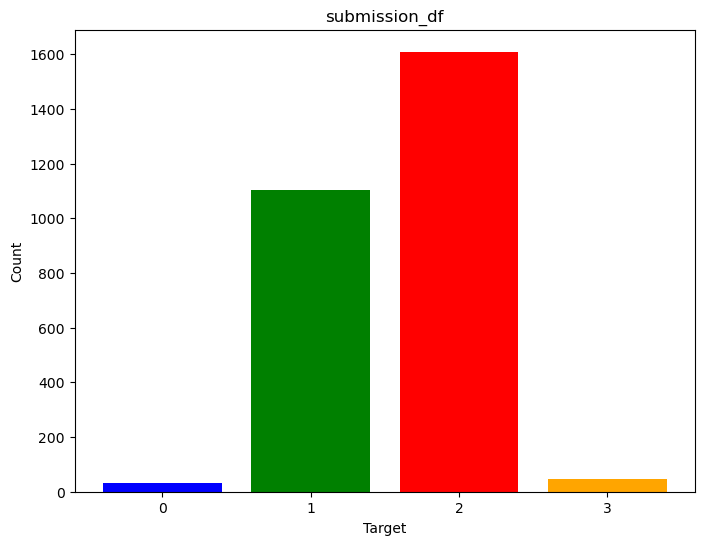

In [14]:
value_counts = submission_df['target'].value_counts().sort_index()

plt.figure(figsize=(8, 6))
plt.bar(value_counts.index, value_counts.values, color=['blue', 'green', 'red', 'orange'])
plt.xticks([0, 1, 2, 3])
plt.xlabel('Target')
plt.ylabel('Count')
plt.title('submission_df')
plt.show()

In [15]:
# TSCV 활용
from time_series_CV import TimeSeriesCV as tsCV
ts = tsCV(train_df)
ts.train()

Fold accuracy: 0.4089041095890411
Fold accuracy: 0.4226027397260274
Fold accuracy: 0.3780821917808219
Fold accuracy: 0.4417808219178082
Fold accuracy: 0.4301369863013699
     Fold  Accuracy
0  Fold 1  0.408904
1  Fold 2  0.422603
2  Fold 3  0.378082
3  Fold 4  0.441781
4  Fold 5  0.430137


C:\Users\Minari\anaconda3\envs\bProject01\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [16]:
ts.print_performance()

F1 Score: 0.242063297467596
Precision: 0.2885153413569669
Recall: 0.2637237451793914
Confusion Matrix: 
[[  0  73  45   1]
 [  0 336 242   2]
 [  0 338 290   2]
 [  0  75  54   2]]


In [17]:
ts_pred = ts.model.predict(test_df.drop(['target', 'ID'], axis = 1))
ts_submission_df = submission_df.assign(target = ts_pred)
ts_submission_df['target'].value_counts()

target
1    1608
2    1096
3      86
0       2
Name: count, dtype: int64

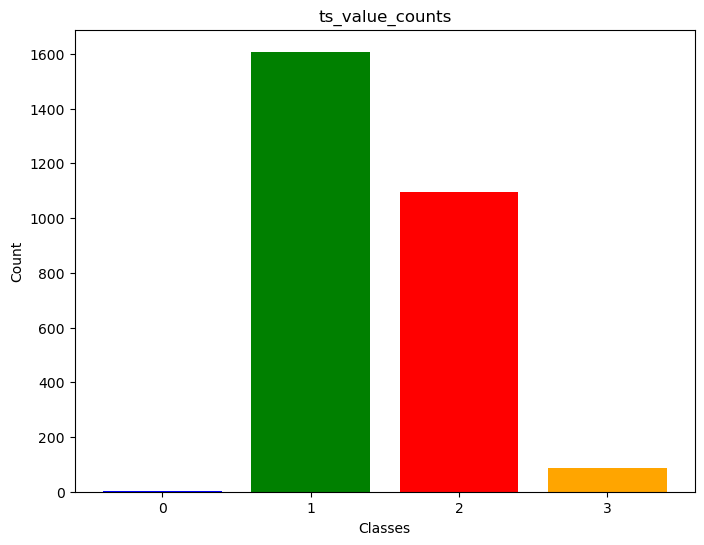

In [18]:
ts_value_counts = ts_submission_df['target'].value_counts().sort_index()

plt.figure(figsize=(8, 6))
plt.bar(ts_value_counts.index, ts_value_counts.values, color=['blue', 'green', 'red', 'orange'])
plt.xticks([0, 1, 2, 3])
plt.xlabel('Classes')
plt.ylabel('Count')
plt.title('ts_value_counts')
plt.show()

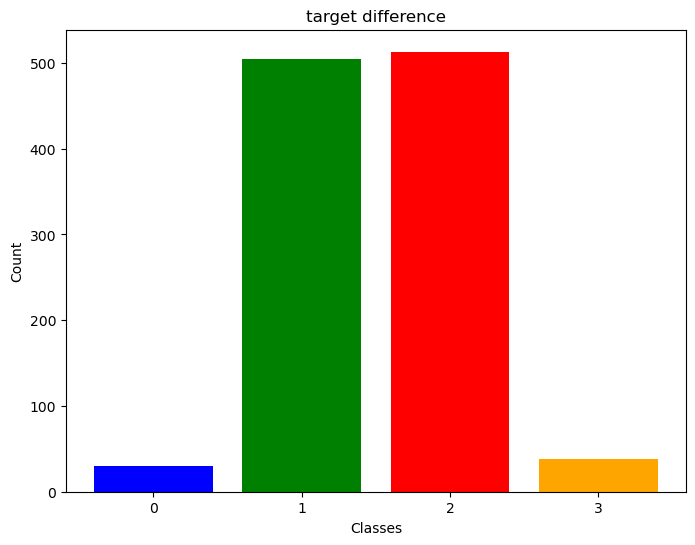

In [19]:
ts_value_counts = ts_submission_df['target'].value_counts().sort_index()

plt.figure(figsize=(8, 6))
plt.bar(ts_value_counts.index, abs(ts_value_counts.values-value_counts.values), color=['blue', 'green', 'red', 'orange'])
plt.xticks([0, 1, 2, 3])
plt.xlabel('Classes')
plt.ylabel('Count')
plt.title('target difference')
plt.show()

In [20]:
submission_df: pd.DataFrame = pd.read_csv(os.path.join('../../data/', "test.csv"))
y_test_pred = lgb_model.predict(test_df.drop(["target", "ID"], axis = 1))
y_test_pred_class = np.argmax(y_test_pred, axis = 1)
ts_submission_df = ts_submission_df.assign(target = y_test_pred_class)
ts_submission_df.to_csv(output_csv_name, index=False)